In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import numpy as np

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda:0


In [4]:

# Set the path to the training and testing directories
drive_dir = "/content/drive/MyDrive/OCT PVD/ZhangLabData/"
drive_dir = "/content/"
drive_dir = ""

train_dir = 'D:/Penkova L2/images/CellData/OCT/train'
train_dir = drive_dir + "CellData/OCT/train"
test_dir = 'D:/Penkova L2/images/CellData/OCT/test'
test_dir = drive_dir + "CellData/OCT/test"





In [ ]:

from torchvision.transforms import functional as F
import cv2
import numpy as np

class CLAHETransform:
    def __call__(self, img):
        # Convert the PIL image to a NumPy array
        img_np = np.array(img)  # Convert to NumPy array

        # Convert to grayscale
        img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

        # Apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img_gray)

        # Convert back to 3-channel image (repeat gray channel across RGB channels)
        img_clahe_rgb = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB)

        # Convert back to a tensor for the model pipeline
        img_tensor = (img_clahe_rgb)

        return img_tensor

# Use the CLAHETransform in your transforms pipeline
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    CLAHETransform(),  # Apply CLAHE
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    # transforms.Resize(256),
    transforms.Resize((224, 224)),
    CLAHETransform(),  # Apply CLAHE
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [44]:
class CannyEdgeTransform:
    def __call__(self, img):
        # Convert the PIL image to a NumPy array
        img_np = np.array(img)

        # Convert to grayscale
        img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

        # Apply Canny Edge Detection
        edges = cv2.Canny(img_gray, threshold1=100, threshold2=200)

        # Convert back to 3-channel image (repeat edges across RGB channels)
        img_edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

        # Convert back to a tensor
        img_tensor = (img_edges_rgb)

        return img_tensor

# Use the CannyEdgeTransform in your transforms pipeline
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    CannyEdgeTransform(),  # Apply Canny edge detection
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(15),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    # transforms.Resize(256),
    transforms.Resize((224, 224)),
    CannyEdgeTransform(),  # Apply Canny edge detection
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


range of pixel intensity - consistent range
customize mean and std
cropping
denoising
histogram equalization

1500 images + 1300 val

hugging face models

In [48]:
# Define transforms for training and testing data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomResizedCrop(224),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    # transforms.Resize(256),
    transforms.Resize((224, 224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [49]:
# Load training and testing datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

In [50]:
# Denormalize function to convert back to original image range
def denormalize(img, mean, std):
    img = img * std[:, None, None] + mean[:, None, None]  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values between 0 and 1
    return img

# Visualize image samples from each class
def visualize_samples(dataset, classes, num_images_per_class=3):
    # Initialize the plot
    fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(num_images_per_class * 3, len(classes) * 3))

    class_counts = {cls: 0 for cls in classes}
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Iterate through dataset to find and plot images from each class
    for img, label in dataset:
        class_name = classes[label]
        if class_counts[class_name] < num_images_per_class:
            # Denormalize the image
            img = img.numpy()
            img = denormalize(img, mean, std)
            img = np.transpose(img, (1, 2, 0))  # Change from (C, H, W) to (H, W, C) for plotting
            
            # Plot the image
            ax = axes[label, class_counts[class_name]]
            ax.imshow(img)
            ax.set_title(f'Class: {class_name}')
            ax.axis('off')
            
            # Increment the count for that class
            class_counts[class_name] += 1
            
        # Stop if we have enough images for all classes
        if all(count >= num_images_per_class for count in class_counts.values()):
            break
    
    plt.tight_layout()
    plt.show()


In [51]:
classes = train_dataset.classes  # or test_dataset.classes
classes

['CNV', 'DME', 'DRUSEN', 'NORMAL']

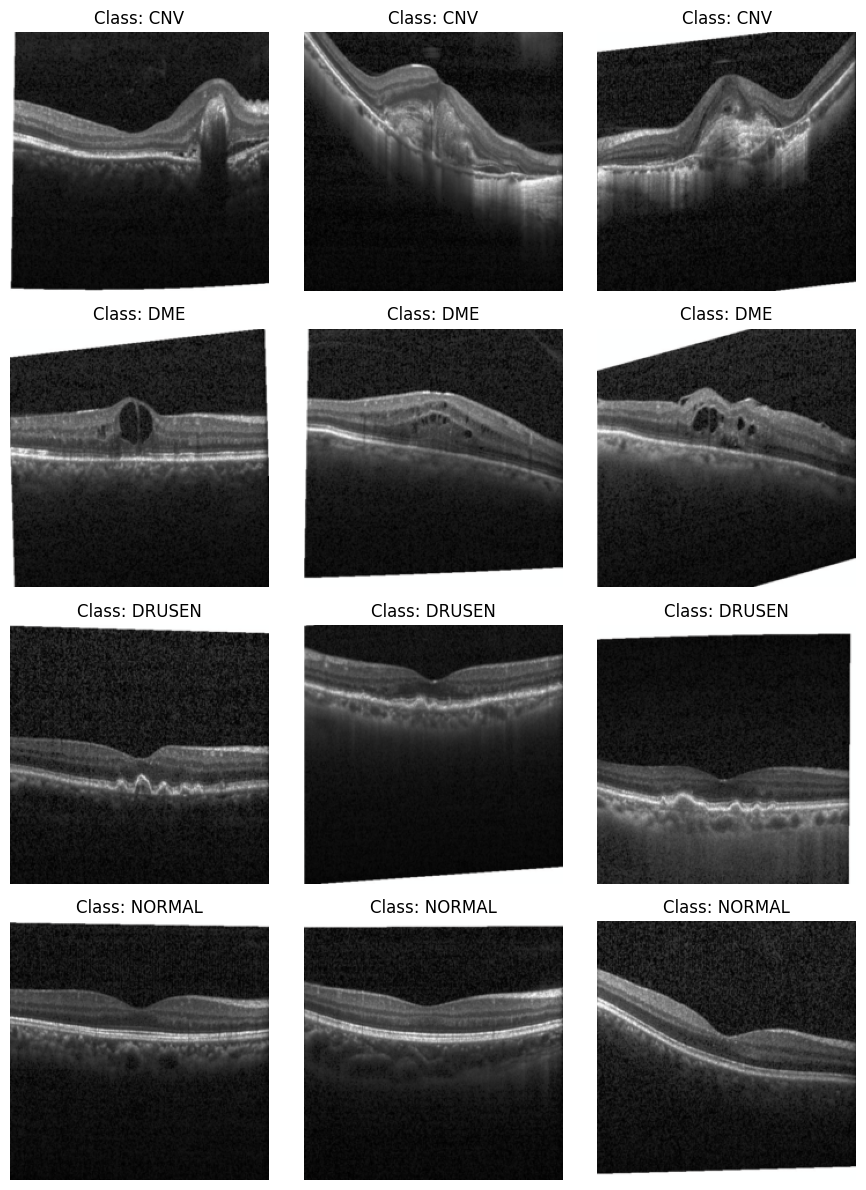

In [52]:
visualize_samples(test_dataset, classes)

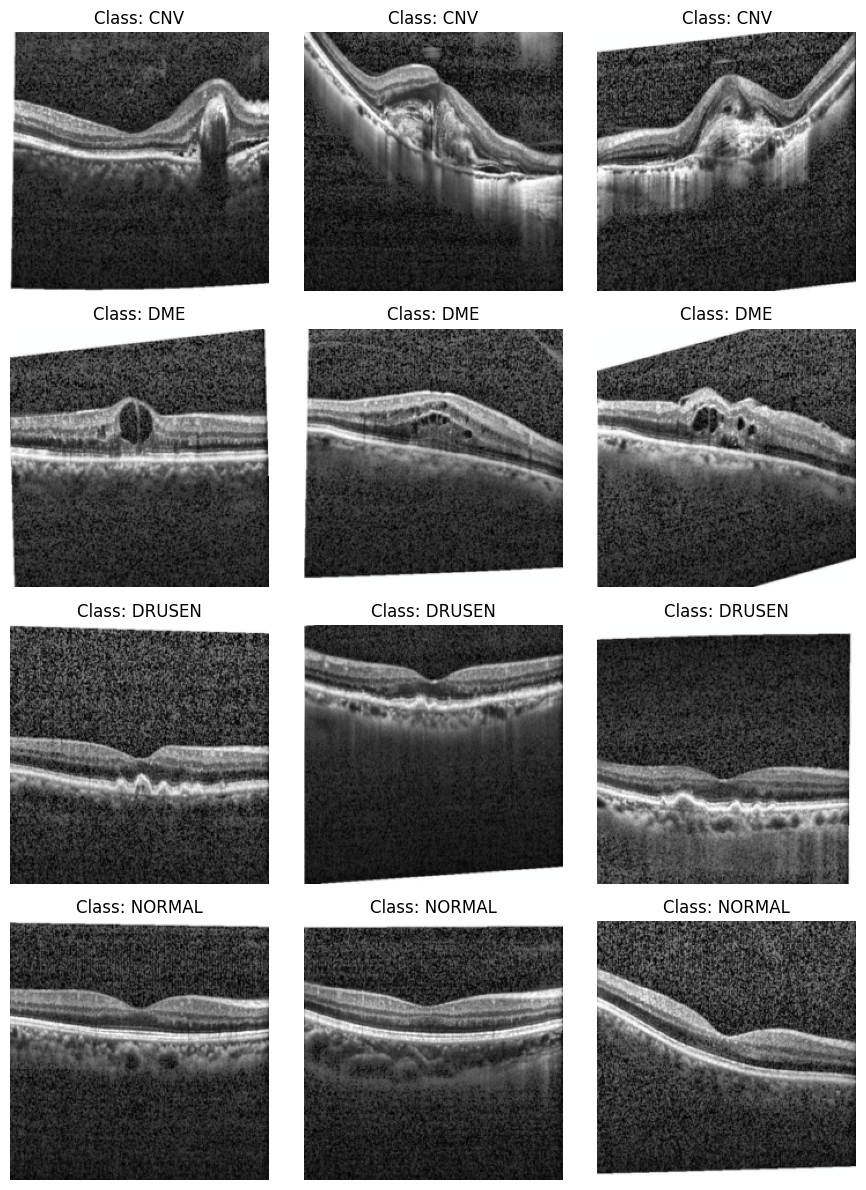

In [37]:
visualize_samples(test_dataset, classes)

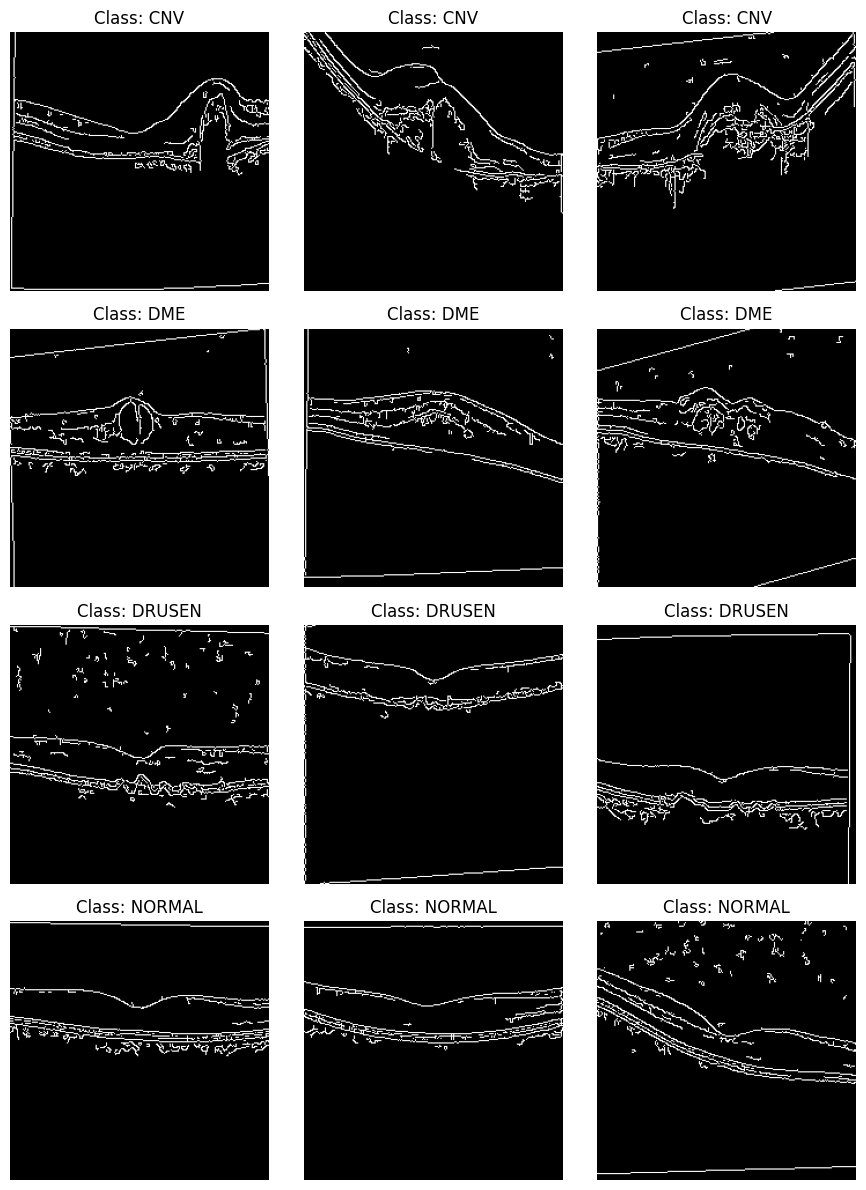

In [47]:
visualize_samples(test_dataset, classes)

Preprocessing, class imbalance and weights, transfear learning fromm xray, ultrasound, ensemble learning, voting

Optic Disc Detection and Masking: The optic disc (bright circular region) might introduce bias. If available, you can preprocess the images to mask or remove the optic disc, allowing the model to focus on the pathological features.

Vessel Enhancement: Blood vessels are key in identifying some conditions. Applying vessel enhancement techniques like Frangi filters or wavelet transforms can highlight the vascular structures in retinal images.

In [19]:
from collections import Counter

# Assuming you have already defined your dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

# Count the number of occurrences of each label
class_counts = Counter(train_dataset.targets)

# Get the class names (corresponding to the indices)
classes = train_dataset.classes

# Print the number of samples per class
for class_idx, count in class_counts.items():
    print(f"Class '{classes[class_idx]}' has {count} samples.")


Class 'CNV' has 37205 samples.
Class 'DME' has 11348 samples.
Class 'DRUSEN' has 8616 samples.
Class 'NORMAL' has 51140 samples.


In [20]:
# Dictionary to store indices for each class
from collections import defaultdict
import random
from torch.utils.data import Subset

min_samples_per_class = min(class_counts.values())

class_indices = defaultdict(list)

# Populate the class indices dictionary
for idx, label in enumerate(train_dataset.targets):
    class_indices[label].append(idx)

# Now, take only 'min_samples_per_class' samples from each class
balanced_indices = []

for label, indices in class_indices.items():
    # Randomly sample 'min_samples_per_class' indices from each class
    sampled_indices = random.sample(indices, min_samples_per_class)
    balanced_indices.extend(sampled_indices)

# Create a balanced subset of the original dataset
balanced_train_dataset = Subset(train_dataset, balanced_indices)

# Create a new DataLoader for the balanced dataset
balanced_train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True, drop_last=True)

print(f"Total samples in the balanced dataset: {len(balanced_train_dataset)}")


Total samples in the balanced dataset: 34464


In [25]:
resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = False

# Modify the final fully connected layer to match the number of classes (4 in your case)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 4)  # 4 output classes for your dataset
)

# Move the model to the GPU if available
resnet50 = resnet50.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001)

# Training loop
num_epochs = 20
train_losses, val_losses = [], []


c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sam\miniconda3\envs\pytgpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# class_weights = torch.tensor([1.0, 1.2, 1.5, 1.3]).to(device)  # Adjust based on class frequencies
# criterion = nn.CrossEntropyLoss(weight=class_weights)

# from sklearn.utils.class_weight import compute_class_weight

# # Assuming `train_dataset` is an ImageFolder dataset
# class_counts = [len(np.where(np.array(train_dataset.targets) == i)[0]) for i in range(len(train_dataset.classes))]

# # Compute class weights: (Inverse of frequency)
# class_weights = compute_class_weight('balanced', classes=np.arange(len(class_counts)), y=np.array(train_dataset.targets))
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# # Use the weights in CrossEntropyLoss
# criterion = nn.CrossEntropyLoss(weight=class_weights)



In [53]:
import numpy as np

from tqdm import tqdm
for epoch in (range(num_epochs)):
    # Training phase
    resnet50.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for (inputs, labels) in tqdm((train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    epoch_acc = correct_train / total_train
    torch.save(resnet50.state_dict(), "resnet50_finetuned.pth")

    # Validation phase
    resnet50.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for (inputs, labels) in tqdm((test_loader)):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(test_dataset)
    val_losses.append(val_epoch_loss)
    val_epoch_acc = correct_val / total_val

    print(f"Epoch [{epoch + 1}/{num_epochs}]"
          f" Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}"
          f" Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")



 44%|████▎     | 738/1692 [4:32:38<5:52:26, 22.17s/it] 


KeyboardInterrupt: 

In [4]:
import numpy as np

from tqdm import tqdm
for epoch in (range(num_epochs)):
    # Training phase
    resnet50.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    epoch_acc = correct_train / total_train
    torch.save(resnet50.state_dict(), "resnet50_finetuned.pth")

    # Validation phase
    resnet50.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for _, (inputs, labels) in tqdm(enumerate(test_loader)):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / len(test_dataset)
    val_losses.append(val_epoch_loss)
    val_epoch_acc = correct_val / total_val

    print(f"Epoch [{epoch + 1}/{num_epochs}]"
          f" Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}"
          f" Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")



  5%|▌         | 1/20 [1:24:08<26:38:44, 5048.67s/it]

Epoch [1/20] Train Loss: 0.5529, Train Acc: 0.8092 Val Loss: 0.4728, Val Acc: 0.7656


 10%|█         | 2/20 [2:58:21<27:01:08, 5403.78s/it]

Epoch [2/20] Train Loss: 0.4897, Train Acc: 0.8311 Val Loss: 0.4533, Val Acc: 0.8063


 15%|█▌        | 3/20 [4:26:19<25:14:49, 5346.43s/it]

Epoch [3/20] Train Loss: 0.4654, Train Acc: 0.8404 Val Loss: 0.5288, Val Acc: 0.7625


 20%|██        | 4/20 [6:08:02<25:05:23, 5645.20s/it]

Epoch [4/20] Train Loss: 0.4520, Train Acc: 0.8444 Val Loss: 0.4653, Val Acc: 0.8000


 25%|██▌       | 5/20 [7:49:41<24:12:15, 5809.02s/it]

Epoch [5/20] Train Loss: 0.4458, Train Acc: 0.8462 Val Loss: 0.5815, Val Acc: 0.7365


 30%|███       | 6/20 [9:31:32<22:59:22, 5911.58s/it]

Epoch [6/20] Train Loss: 0.4320, Train Acc: 0.8510 Val Loss: 0.5072, Val Acc: 0.7604


 35%|███▌      | 7/20 [11:13:35<21:35:49, 5980.74s/it]

Epoch [7/20] Train Loss: 0.4284, Train Acc: 0.8524 Val Loss: 0.5392, Val Acc: 0.7656


 35%|███▌      | 7/20 [12:40:19<23:32:02, 6517.10s/it]


KeyboardInterrupt: 

In [ ]:
# Save the trained model
torch.save(resnet50.state_dict(), drive_dir+"resnet50_finetuned.pth")

# torch.save(resnet50.state_dict(), "/content/drive/MyDrive/OCT PVD/resnet50_finetuned.pth")



In [ ]:

# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()